
$$\newcommand{\vec}[1]{{\bf #1} } 
\newcommand{\real}{\mathbb{R} }
\newcommand{\expect}[1]{\mathbb{E}[#1] }
\DeclareMathOperator*{\argmin}{arg\,min}
\DeclareMathOperator*{\argmax}{arg\,max}
\newcommand{\E}{\mathbb{E}}$$
<img src="imgs/school-logo.png">

# Day 5: Bayesian Optimization 

### June 17, 2022

---
## Antti Oulasvirta / Aalto University 

Authors:
* antti.oulasvirta@aalto.fi / [Aalto User Interfaces group](http://userinterfaces.aalto.fi)
* yi-chi.liao@aalto.fi / [Aalto User Interfaces group](http://userinterfaces.aalto.fi)
* tomi.peltola@aalto.fi / [Aalto Probabilistic Machine Learning Group](http://www.tmpl.fi)


## Learning goals

After this lecture and the exercises, you should

 1. understand three basic concepts of Bayesian optimization: acquisition function, proxy model, and the exploration/exploitation problem,
 2. know when it can serve as a useful tool and when not,
 3. be able to use GPyOpt for your an HCI application.


## Table of contents

 1. Introduction
 2. Applications
 3. Bernoulli bandit
 4. Bayesian optimization 
 5. Acquisition functions
 6. Hands-on example
 7. Looking forward

<p>
<div class="alert alert-block alert-success"> 
<h3>Warm-up: Color Oracle</h3> 
<br>
This game requires two players: Player A (Oracle) and Player B (Optimizer). Player A thinks about the two most beautiful colors. Player B's task is to figure out what these colors are *in eight questions*. Only one color can be queried in one question. When asked about a color, Player A must tell how beautiful it is on a scale from 1 (worst) to 5 (best). After the eighth question, Player B must propose which two colors are Player A's favorites.</div>
</p>


---
# 1. Introduction
Bayesian optimization is both an optimization method and an interactive machine learning method. What does this mean?

### Optimization

Optimization, in general, refers to the identification of parameter values that obtain the optimal value of an objective function. 
More precisely, the computational problem in optimization is to find the minimum (or maximum) of a function $f(x)$ within some bounded domain $\mathcal{X} \subset \mathbb{R}^D$:

$$x^* = \argmin_{x \in \mathcal{X}} f(x)$$

**How would you normally solve this?**

 * Trial and error
 * Random search
 * Grid search
 * Evolutationary algorithms
 * Integer programing
 * ...

What are the pros and cons of different approaches? 

### Interactive machine learning

<div class="center">
<img src="imgs/iml.png" style="width: 50%" />
</div>

''Interactive Machine Learning is an interaction paradigm in which a user or user group iteratively builds and refines a mathematical model to describe a concept through iterative cycles of input and review.'' [Dudley and Kristensson 2018 TIIS](https://dl.acm.org/doi/pdf/10.1145/3185517)

Within IML, Bayesian optimization is an *active learning* method. In other words, it does not rely on a static dataset being given, but picks samples from the world (active) to build a model (learning), and then use it for something.

### Bayesian optimization

Bayesian optimization is a modern, probabilistic approach to human-in-the-loop optimization / machine learning. It is a robust and sample-efficient approach to black-box optimization. It offers a principled solution to the exploration/exploitation problem. These properties make it well-suited for human-in-the-loop optimization. 

Let's break this down:

**Multidimensional decision spaces**: Typical to HCI, there is not only one decision variable to decide but multiple. In our studies using Bayesian optimization, our problems have had between 2 and 12 decision variables. These variables can be continuous, discrete, or binary, although for simplicity we often use continuous variables only.

**Multi-objective problems**: Typical to HCI, there is typically more than one objective to to consider.

**Complex objective functions**: In HCI, we may not always rely our objectives to clean gradients to exploit nor that being unimodal. 

**Human-in-the-loop**: One or more terms in the objective function are human-defined. In practice, candidate solutions are presented to a human(s) for evaluation. (ML interpretation: learning samples come from humans.)

**Black-box**: because evaluations rely on humans, the objective function is not known (c.f., mathematically defined objective functions). In this case, the objective function can be thought as an 'oracle' from which the solver can query objective values: 'How good is this candidate?'

**Expensive evaluations**: Humans are expensive to query, time- and money-wise. By contrast, in integer programming that uses mathematically defined objective functions, evaluations are very fast, up to millions per second.

**Noisy evaluations**: Unlike formal objective functions, humans are not 100% accurate not consistent with their evaluations. They show carry-over effects (e.g., learning, fatiguing), biases (e.g., status quo bias), and generally large inter- and intra-individual variability.

### Operating principle

Bayesian optimization uses a **proxy model** for estimating how objective values are distributed across the parameter space. In most applications, Gaussian Process models are used because of some favorable properties, but in principle it can be any Bayesian probability model. The presence of a model is a point of deviation from most other optimization methods. Being Bayesian, the proxy model offers a posterior probability for the distribution the objective value across the parameter space. Using Bayes theorem for updating these estimates increases robustness to noise. 

Moreover, thanks to the proxy model, we can estimate where the best parameter values *might* be, even if it is outside of previously seen samples. This provides a means for solving the exploration/exploitation problem. This is achieved by making an additional assumption: **acquisition function**. It selects which parameter values are sampled next, based on the proxy model. This is the key to the sample-efficiency of Bayesian optimization. One way to think about is that it helps wasting samples in areas are already found to be less promising.

Recipe:

1. **Acquire: pick the next parameter combination to sample:** At the beginning of each round, the acquisition rule is used to select a set of parameter values that will be queried. The locations are balanced such that they cover both unknown regions of the parameter space (**exploration**) and regions with high probability to lead to high values (**exploitation**). 
2. **Update the proxy model:** After predictions have been generated at each location, the surrogate model is updated based on the observations, and the next optimization round begins. 
3. **Iterate**. After the maximum budget of iterations has been exhausted, optimal parameter values are picked based on the proxy model. For example, we can pick the values that lead to best predicted objective value on average.

[Visual overview](imgs/example2.png). Source: https://modal-python.readthedocs.io


# 2. Applications 
Applications of Bayesian optimization require:
1. A bounded domain, i.e. some multidimensional but limited parameter space
2. At least one human-evaluatable objective. The more quicker and more reliably this can be measured, the better!
3. Some way for humans to evaluate candidates picked by the optimizer.


## MVT testing

In multi-variate testing (MVT), we want to evaluate which service design is optimal for, e.g., click-through rate, retention time, or purchases, user satisfaction, interest, or revenue.
MVT is a generalization of AB testing that compares two designs at a time.

By choosing samples wisely, Bayesian optimization can converge to a good design quicker and avoid contaminating consumers with potentially bad designs.

## Computational design

In computational design, we want to find a combination of design variables that optimize some objective function. For example, generate procedural animations by asking humans to rate generated examples:

<div class="center">
<img src="imgs/anim.png" style="width: 50%" />
</div>

<div style="font-size: 10px;"><a href="https://dl.acm.org/citation.cfm?id=1921443">[image: Brochu et al., 2010]</a></div>

We will return to this example later on.

## Design optimization

Here we let Bayesian optimization to decide design parameters with the attempt of finding the best possible design within a design space. (Compare: in computational design, one may also want to for example explore a design space or tune a given design.)

<div class="center">
<img src="imgs/liao.png" style="width: 90%" />
</div>

<a href="https://dl.acm.org/doi/pdf/10.1145/3491102.3501850">Liao et al. CHI'22</a>

[CHI'22 preview video](https://www.youtube.com/watch?v=uK4o_2VY90E)


## Personalization

In personalization, we tune the parameters of an interactive system to an individual.
For example, optimizing step rate to minimize metabolic cost.

<div class="center">
<img src="imgs/wearable_devices.png" style="width: 70%" />
</div>

<div style="font-size: 10px;"><a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0184054">[image: Kim et al., 2017]</a></div>

Another example: [Personalizing an exosuit for hip assistance](https://www.youtube.com/watch?v=eeplAvCr5zM)

## Inverse modeling

In forward modeling, we create a model and use it to make predictions with different inputs and parameters.
In inverse modeling, we change the parameters of a model such that it can reproduce real (human) data as close as possible. 
For example, fitting parameters of cognitive simulators to experimental data.

<div class="center">
<img src="imgs/abc2.png" style="width: 60%" />
</div>

<div style="font-size: 10px;"><a href="https://dl.acm.org/citation.cfm?doid=3025453.3025576">[image: Kangasraasio et al., 2017]</a></div>

## Others

 * Recommender systems
 * Sensor networks
 * Hyperparameter optimization in ML systems
 * Robotics 

## The computational problem: Recap

**Problem:** Find the minimum of a function $f(x)$ within some bounded domain 

$$\mathcal{X} \subset \mathbb{R}^D:$$

$$x^* = \argmin_{x \in \mathcal{X}} f(x)$$

**Challenges**
 * $f$ is a black-box that we can only evaluate point-wise, 
 * $f$ can be multi-modal,
 * $f$ is slow or expensive to evaluate,
 * evaluations of $f$ are noisy,
 * $f$ has no gradients available (but they can be used if they are available).

** Basic idea of Bayesian optimization **

We want to find the minimum with small number of evaluations of $f$. Solution:

 1. Construct a tractable **statistical proxy model** of $f$.
 2. Turn the optimization problem into **a sequence of easier problems**.

---

# 3. Bernoulli bandit

*Before full-blown Bayesian optimization with GPs, we look at a simpler, so-called bandit problem first.*

**Task**: Conduct an A/B test to find which of two versions of a Web ad is better; that is, which ad gets most clicks.

Nomenclature:
 * **Experiment**: Show either of the two versions to a visitor.
 * **Observation**: Did the visitor click the ad.
 
Minimize *regret* $R$ for $T$ experiments:
$$R = T \E[y^*] - \sum_{t=1}^T y_t$$
 * $\E[y^*]$ is the expected click rate for the better ad,
 * $y_t \in \{0,1\}$ is whether visitor $t$, who was shown version $x_t \in \{A, B\}$, clicked the ad.

 * Model click rates of $A$ and $B$ independently. Equations for A below.
 
**Bayes theorem**: $p(\theta \mid \mathcal{D}) = \frac{p(\mathcal{D} \mid \theta)}{p(\mathcal{D})} p(\theta)$ updates **prior** knowledge $p(\theta)$ with **observations** $\mathcal{D}$ to **posterior** knowledge $p(\theta \mid \mathcal{D})$.

Observation model:

$$\Pr(y_t \mid x_t = A) = \textrm{Bernoulli}(y_t \mid \rho_A) = \rho_A^{y_t} (1 - \rho_A)^{1-y_t}.$$

Prior model:

$$p(\rho_A) = \textrm{Beta}(\rho_A \mid \alpha, \beta) = \frac{1}{B(\alpha, \beta)} \rho_A^{\alpha-1} (1 - \rho_A)^{\beta-1}.$$

Given a dataset of $t$ observations $\mathcal{D}_t = \{(x_1, y_1), \ldots, (x_t, y_t)\}$, the posterior distribution is
$$p(\rho_A \mid \mathcal{D}_t) = \frac{p(\rho_A) \prod_{t: x_t = A} \Pr(y_t \mid x_t = A)}{\int_0^1 p(\rho_A) \prod_{t: x_t = A} \Pr(y_t \mid x_t = A) d\rho_A} = \textrm{Beta}(\rho_B \mid \alpha + n^{A}_1, \beta + n^{A}_0),$$
where $n^{A}_1$ and $n^{A}_0$ are the total numbers of $y_t = 1$ and $y_t = 0$ for $x_t = A$.



In [2]:
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt

x = np.linspace(0, 1, 101)

plt.plot(x, scipy.stats.beta.pdf(x, 1, 1), 'b-', label='Prior Beta(1,1)')
plt.xlabel(r'Click rate $\rho_A$')
plt.ylim(0, 2.5)
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

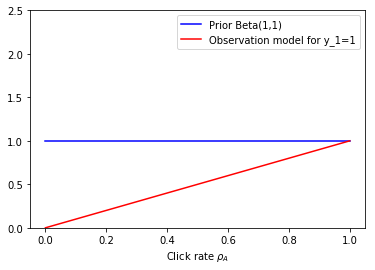

In [3]:
plt.figure()
plt.plot(x, scipy.stats.beta.pdf(x, 1, 1), 'b-', label='Prior Beta(1,1)')
plt.plot(x, x, 'r-', label='Observation model for y_1=1')
plt.xlabel(r'Click rate $\rho_A$')
plt.ylim(0, 2.5)
plt.legend()
plt.show()

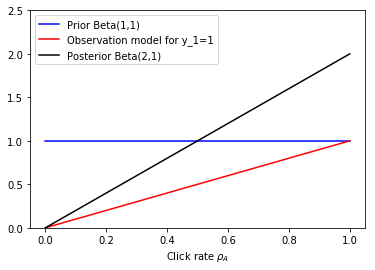

In [4]:
plt.figure()
plt.plot(x, scipy.stats.beta.pdf(x, 1, 1), 'b-', label='Prior Beta(1,1)')
plt.plot(x, x, 'r-', label='Observation model for y_1=1')
plt.plot(x, scipy.stats.beta.pdf(x, 2, 1), 'k-', label='Posterior Beta(2,1)')
plt.xlabel(r'Click rate $\rho_A$')
plt.ylim(0, 2.5)
plt.legend()
plt.show()

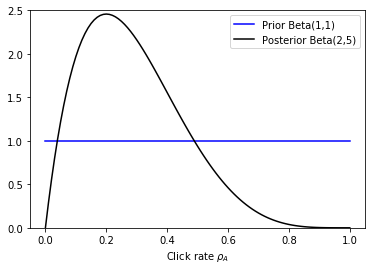

In [5]:
plt.figure()
plt.plot(x, scipy.stats.beta.pdf(x, 1, 1), 'b-', label='Prior Beta(1,1)')
plt.plot(x, scipy.stats.beta.pdf(x, 2, 5), 'k-', label='Posterior Beta(2,5)')
plt.xlabel(r'Click rate $\rho_A$')
plt.ylim(0, 2.5)
plt.legend()
plt.show()

## Thompson sampling

When $t+1$th visitor comes, which ad, $A$ or $B$, to serve?

 * Want to exploit: gather as much clicks as possible.
 * Need to explore: learn about click rates for A and B.
 
Thompson sampling is a simple algorithm navigating this trade-off:

 1. Sample a value for $\hat{\rho}_A$ and for $\hat{\rho}_B$ from $p(\rho_A \mid \mathcal{D}_t)$ and $p(\rho_B \mid \mathcal{D}_t)$.
 2. Show $A$ if $\hat{\rho}_A > \hat{\rho}_B$ and $B$ otherwise.
 
We then observe whether the visitor clicked the ad or not and update our posterior distributions and continue to next iteration.

## Example 
*How does Thompson sampling navigate exploration-exploitation trade-off?*

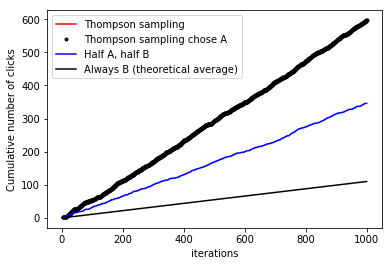

In [6]:

rho_A_true = 0.6; rho_B_true = 0.11 # simulated visitor click rates
alpha = 1; beta = 1 # prior parameters
n_A1 = 0; n_A0 = 0; n_B1 = 0; n_B0 = 0 # numbers of clicks/no-clicks
T = 1000 # number of iterations
clicks = np.zeros(T); A_or_B = np.zeros(T)

for t in range(T):
    # Thompson sampling
    rho_A = np.random.beta(alpha + n_A1, beta + n_A0)
    rho_B = np.random.beta(alpha + n_B1, beta + n_B0)
    if rho_A > rho_B: # which ad to show
        y_t = np.random.binomial(1, rho_A_true) # simul. click
        n_A1 += y_t; n_A0 += 1 - y_t; # update posterior of A
    else:
        y_t = np.random.binomial(1, rho_B_true) # simul. click
        n_B1 += y_t; n_B0 += 1 - y_t; # update posterior of B
    # collect statistics
    clicks[t] = y_t; A_or_B[t] = rho_A > rho_B
    
# instead of Thompson sampling, allocate same numbers to A and B
clicks_half = np.zeros(T)

for t in range(T):
    if t % 2 == 0:
        y_t = np.random.binomial(1, rho_A_true)
    else:
        y_t = np.random.binomial(1, rho_B_true)
    clicks_half[t] = y_t
    
plt.figure()
plt.plot(range(1,T+1), np.cumsum(clicks), 'r-', label='Thompson sampling')
plt.plot(np.array(range(1,T+1))[A_or_B==1], np.cumsum(clicks)[A_or_B==1], 'k.', label='Thompson sampling chose A')
plt.plot(range(1,T+1), np.cumsum(clicks_half), 'b-', label='Half A, half B')
plt.plot(range(1,T+1), np.array(range(1,T+1)) * rho_B_true, 'k-', label='Always B (theoretical average)')
plt.xlabel('iterations')
plt.ylabel('Cumulative number of clicks')
plt.legend(loc=2)
plt.show()

---

# 4. Bayesian Optimization

## Computational problem and approach

Again, the task is to find the minimum of a function $f(x)$ within some bounded domain $\mathcal{X} \subset \mathbb{R}^D$:

$$x^* = \argmin_{x \in \mathcal{X}} f(x)$$

We often want to find this with a small number of evaluations of $f$.

Bayesian optimization approaches this problem with a two-pronged approach:
 1. Construct a tractable proxy model of $f$.
 2. Turn the optimization problem into a sequence of easier, experimental design problems. Experimental design refers to the problem of deciding which condition (sample) to try next, given observation history.

### Step 1. Create a proxy model

"A **proxy model** is an engineering method used when an outcome of interest cannot be easily directly measured, so a model of the outcome is used instead." (Wikipedia)
 
Let $g(x)$ be our **proxy model** of $f$.

 * $g$ should be able to capture important aspects of $f$ from small number of evaluations.
 * Need to be able to update $g$ when we acquire new evaluations of $f$: $g$ should get better and better as a model of $f$.
 * $g$ should be fast to evaluate and to update.
 * $g$ needs to cope with noise.
 * Need to be able to quantify uncertainty in $g$
 * Need to navigate the exploration-exploitation tradeoff.

#### Gaussian processes

Gaussian process (GP) regression models are commonly used surrogate models used in BO. This is because of its capacity to approximate a large subset of model fit surfaces that are encountered in practice. GP models are also able to model the stochasticity of model fit, thus allowing a principled estimation of its mean and variance everywhere in the parameter search space.

 * Gaussian processes provide a probability distribution over functions.
 * Extends (and uses properties of) the multivariate normal distribution $\Rightarrow$ computationally tractable.
 * Prior information about the type or behaviour of the modelled function can be included in the *covariance function* and its parameters.
 
 * Alternatives: random forests, Bayesian neural networks.
 
<p>
<div class="alert alert-block alert-success"> 
<h3>In-class exercise.</h3> 
<br>
Open the [Interactive demo app](http://www.tmpl.fi/bayesian-optimization/#37). Add 10 observations to the plot simulating some ''hard'' objective function. Now, modify a) length scale and b) noise parameters. Your task now: Find one parameter combination that behaves like ''overfitting'' and another that behaves like ''underfitting''. Note: Length scale describes "how close" two points have to be to influence each other.</div>
</p>
<div id="gp-outer"></div>


### Step 2. Use the proxy model to turn the optimization problem into a sequence of easier problems (experiment design)

Consider having evaluated $f$ at points $x_1, \ldots, x_{t-1}$ and having constructed $p(g \mid \mathcal{D}_{t-1})$.

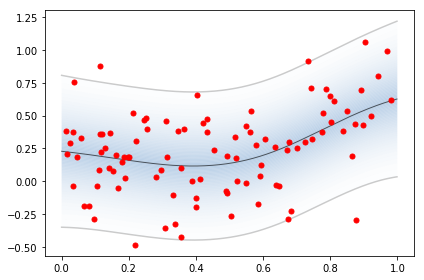

In [8]:
import GPy, GPyOpt
import numpy as np

def f_u(x):
    return x**5 + 0.1 + 0.3 * np.random.randn()

bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (0,1)}]
myBopt = GPyOpt.methods.BayesianOptimization(
    f=f_u, domain=bounds, acquisition_type='EI',
    exact_feval = False, initial_design_numdata=100, normalize_Y=False)
max_iter = 0; max_time = 60; eps = 10e-6

myBopt.run_optimization(max_iter, eps)
myBopt._update_model()
#myBopt.plot_acquisition()
#myBopt.model.model.plot([0.0,1.0])
model = myBopt.model.model

x_grid = np.arange(0, 1, 0.001)
x_grid = x_grid.reshape(len(x_grid),1)
m, v = model.predict(x_grid)

model.plot_density([0,1], alpha=.5)

plt.plot(x_grid, m, 'k-',lw=1,alpha = 0.6)
plt.plot(x_grid, m-1.96*np.sqrt(v), 'k-', alpha = 0.2)
plt.plot(x_grid, m+1.96*np.sqrt(v), 'k-', alpha=0.2)

Xdata, Ydata = myBopt.get_evaluations()

plt.plot(Xdata, Ydata, 'r.', markersize=10)

plt.show()

How to choose the next $x$ to evaluate $f$ at?

**What would you do?**

Consider having evaluated $f$ at points $x_1, \ldots, x_{t-1}$ and having constructed $p(g \mid \mathcal{D}_{t-1})$:

<Figure size 432x288 with 0 Axes>

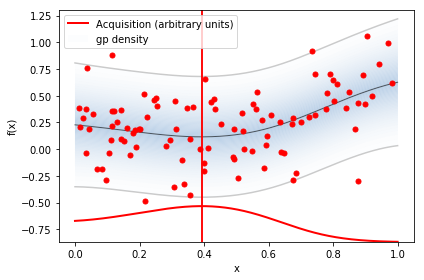

In [9]:
plt.figure()
myBopt.plot_acquisition()

---- 
# 5. Acquisition functions 
How to choose the next $x$ to evaluate $f$ at?

**Guided exploration** using $p(g \mid \mathcal{D}_{t-1})$:

 * Trade off exploration (reducing uncertainty) and exploitation (sampling near likely places of optima).
 * Formulated by maximizing an acquisition function $\alpha(x; \mathcal{D}_{t-1})$.
 
$$x_{t} = \argmax_x \alpha(x; \mathcal{D}_{t-1})$$

**Thompson sampling** acquisition function:

 * $\alpha(x; \mathcal{D}_{t-1}) = \hat{g}(x)$, where $\hat{g}(x)$ is a sample from $p(g \mid \mathcal{D}_{t-1})$.

**Expected improvement** acquisition function:

 * Currently best value $y^* = \max_{s \in \{1,\ldots,t-1\}} y_s$.
 * Improvement function provides utility of $x$ given $g$: $I(x, g) = (g(x) - y^*) I(g(x) > y^*)$.
 * Expected improvement: $\alpha_{EI}(x; \mathcal{D}_t) = \E_g[I(x, g)]$.

[Visual example](imgs/ei.png)

Many others also exists! 

## Bayesian Optimization Recipe

**Goal**: Find the minimum of a function $f(x)$ within some bounded domain $\mathcal{X} \subset \mathbb{R}^D$:

$$x^* = \argmin_{x \in \mathcal{X}} f(x)$$

**Key ideas**

 1. Construct a tractable statistical surrogate model of $f$.
 2. Turn the optimization problem into a sequence of easier problems.

**Algorithm**

 1. Initialize dataset $\mathcal{D}_0$, surrogate model $p(g \mid \mathcal{D}_0)$; choose acquisition function $\alpha(\cdot)$.
 2. Loop for $t = 1,2,\ldots,T$:
      1. Select next evaluation point: $x_{t} = \argmax \alpha(x; \mathcal{D}_{t-1})$.
      2. Evaluate $f(x_{t})$ to obtain $y_{t}$.
      3. Update dataset $\mathcal{D}_{t} = \{\mathcal{D}_{t-1},(x_t, y_t)\}$.
      4. Update surrogate model $p(g \mid \mathcal{D}_t)$.
 3. Report the found optimum.
 

## GPyOpt

We create a mathematically well-defined objective function and use it to test how GPyOpt works.

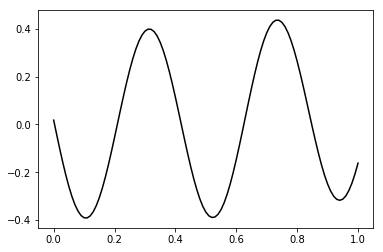

In [11]:
def f_u(x):
    return 0.2 * (x - 0.3)**2 - 0.4 * np.sin(15.0 * x)

plt.figure(); xx = np.linspace(0, 1, 101)
plt.plot(xx, f_u(xx), 'k-'); plt.show()

In [12]:
bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (0,1)}]
myBopt = GPyOpt.methods.BayesianOptimization(
    f=f_u, domain=bounds,        # Function and domain                 
    acquisition_type='EI',       # Expected improvement
    exact_feval=True,            # Noiseless function evaluations
    eps=1e-6,
    normalize_Y=False,           # (for clearer visualization)
    initial_design_numdata=2)    # (for clearer visualization)

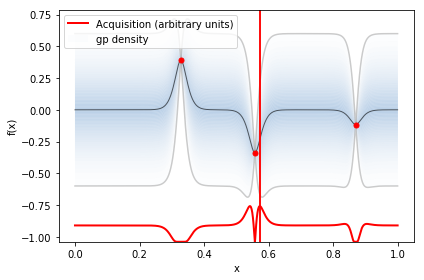

In [13]:
myBopt.run_optimization(max_iter=1)
myBopt.plot_acquisition()

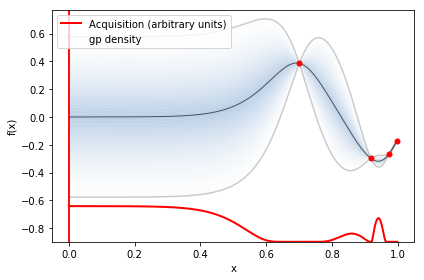

In [17]:
myBopt.run_optimization(max_iter=1)
myBopt.plot_acquisition()

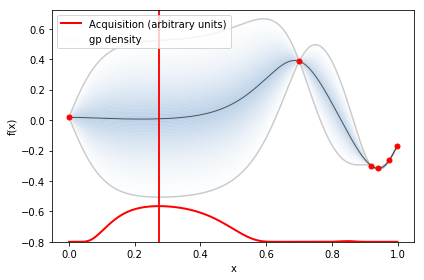

In [19]:
myBopt.run_optimization(max_iter=1)
myBopt.plot_acquisition()

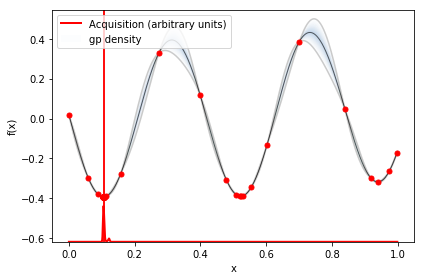

In [20]:
myBopt.run_optimization(max_iter=100)
myBopt.plot_acquisition()

In [ ]:
myBopt.run_optimization(max_iter=1)
myBopt.plot_acquisition()

## Does it work?

Yes and no! Maybe?
 * Theoretical guarantees (regret bounds) exists under some conditions.
 * ''There is still a wide gap between theory and practice.'' - Shahriari et al.
* ''[...]the careful choice of statistical model is often far more important than the choice of acquisition function heuristic.'' - Shahriari et al.

**Known limitations**

 * Difficulties with high-dimensional parameter spaces.
 * Can spend a lot of time at the ''edges of the space'' (Siivola et al., MLSP 2018).
 * Computation complexity of inference in Gaussian processes scales as $O(N^3)$, where $N$ is the number of observations. In this case, sparse GPs/inducing point approximations can be used; or other types of models like amortized inference (e.g., [BayesFlow](https://ieeexplore.ieee.org/abstract/document/9298920)).
 * Optimizing hyperparameters (controlling the behaviour of the surrogate) can be challenging.

---

# 6. Application example

## Revisiting animation design as a case

Two types of rather direct human-in-the-loop applications:
 * Human provides explicit feedback at $x$, the value $f(x)$.
 * Human provides implicit feedback at $x$, for example, $f(x)$ is a completion time of a task with parameters $x$.


Find parameters for generating a procedural fluid animation:
* velocity, radius and magnitude of the (possibly multiple) vortex rings,
* length scale and magnitude of the curl noise,
* relative strengths of vortex rings and curl noise.

User can easily tell which animations look good: ''the psychoperceptual process underlying judgment - how well a realization fits what the user has in mind''.

<div class="center">
<img src="imgs/anim.png" style="width: 50%" />
</div>

*Eric Brochu, Tyson Brochu, Nando de Freitas: A Bayesian Interactive Optimization Approach to Procedural Animation Design, Eurographics/ACM SIGGRAPH Symposium on Computer Animation (2010).*

### User interface
<div class="center">
<img src="imgs/ui.png" style="width: 79%" />
</div>

### Algorithm
<div class="center">
<img src="imgs/bo_alg.png" style="width: 59%" />
</div>

### User study
 * Obtained improved results compared to novice and expert users setting parameters manually.
 * Tailored the Bayesian optimization approach to make it work:
      1. preferential feedbacks,
      2. transfer information over multiple sessions,
      3. combined manual parameter tuning and Bayesian optimization.
      


## Color Preference Learning

<p>
<div class="alert alert-block alert-success"> 
<h3>In-class exercise.</h3> 
<br>
Let's go back to the color oracle game and solve it with Bayesian optimization. Below is a script that implements the color preference elicitation game in the RGB color space. The user is the Oracle (Player A) and the Bayesian optimizer is the Player B. Unfortunately, the optimizer is not very good. (Darn!) It does not get a good preference model in 8 questions. Can you figure out how to improve it?  
<br>
<b>Tip:</b> Could you improve the acquisition function to get it exploit more aggressively? Some acquisitions to look into are: 
‘EI’, expected improvement;
‘MPI’, maximum probability of improvement; and
‘LCB’, GP-Lower confidence bound. 
[Manual page](https://gpyopt.readthedocs.io/en/latest/GPyOpt.methods.html). [Acquisition functions and their parameters](https://gpyopt.readthedocs.io/en/latest/GPyOpt.acquisitions.html).

Report back the acquisition function and its parameters, and the result you got (= how many questions to find the favorited colors).
</div>
</p>




[[0.95005567 0.84912323 0.48611546]]


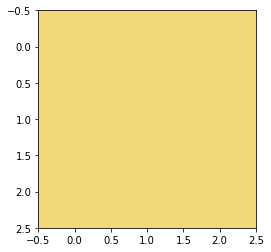

Grade? (0 to 5) 1
[[0.43492893 0.2104412  0.14812252]]


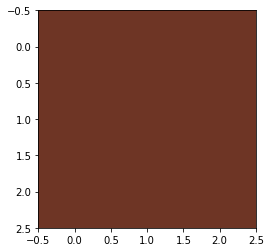

Grade? (0 to 5) 2
[[0.61181604 0.07599126 0.92864078]]


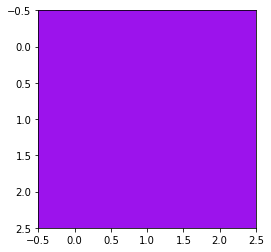

Grade? (0 to 5) 3
[[0.62568403 0.15645794 0.39381105]]


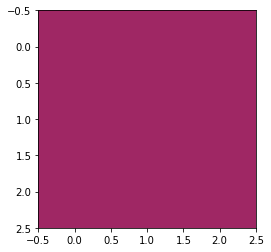

In [ ]:
def f_u(x):
    plt.figure(1)
    print(x)
    im = x.reshape(1, 1, 3).repeat(3, axis=0).repeat(3, axis=1)
    plt.imshow(im)
    plt.show(block=False)
    while True:
        res = input('Grade? (0 to 5) ')
        if res in ['0', '1', '2', '3', '4', '5']:
            res = int(res)
            plt.close(1)
            return res


def run_bo(max_iter):
    bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (0, 1)},
              {'name': 'var_2', 'type': 'continuous', 'domain': (0, 1)},
              {'name': 'var_3', 'type': 'continuous', 'domain': (0, 1)}]
    myBopt = GPyOpt.methods.BayesianOptimization(
        f=f_u, domain=bounds,
        acquisition_type='MPI',
        exact_feval=False,
        eps=1e-6,
        normalize_Y=False,
        initial_design_numdata=10,
        maximize=True)
    myBopt.run_optimization(max_iter=max_iter - 10)

    return myBopt


def run_random(max_iter):
    xs = np.zeros((max_iter, 3))
    ys = np.zeros((max_iter,))

    for i in range(max_iter):
        xs[i, :] = np.random.rand(3)

        ys[i] = f_u(xs[i, :])

    return xs, ys


if __name__ == "__main__":
    n_iter = 2
    # run BO
    bo = run_bo(n_iter)
    # run random for comparison
    n_iter = 2
    ra = run_random(n_iter)

    bo_xs, bo_ys = bo.get_evaluations()
    ra_xs, ra_ys = ra

    # one can investigate these to see how good colors were found and compare
    # to a ground truth color

    plt.plot(-bo_ys, 'k-', label='BO')
    plt.plot(ra_ys, 'r-', label='Random')
    plt.xlabel('iterations')
    plt.ylabel('grades')
    plt.legend()
    plt.show()

    # let's say ground truth color was red
    x_gt = np.array([1.0, 0.0, 0.0])

    plt.plot(np.sqrt(np.sum((bo_xs - x_gt)**2, 1)), 'k-', label='BO')
    plt.plot(np.sqrt(np.sum((ra_xs - x_gt)**2, 1)), 'r-', label='Random')
    plt.xlabel('iterations')
    plt.ylabel('distance from ground truth')
    plt.legend()
    plt.show()



---

# 7. Conclusion 

## Summary
Find the minimum of a function $f(x)$ within some bounded domain $\mathcal{X} \subset \mathbb{R}^D$:

$$x^* = \argmin_{x \in \mathcal{X}} f(x)$$

 * $f$ is a black-box that we can only evaluate point-wise, 
 * $f$ can be multi-modal,
 * $f$ is slow or expensive to evaluate,
 * evaluations of $f$ are noisy,
 * $f$ has no gradients available (can be used if available).

**Key ideas**

 1. Construct a tractable statistical surrogate model of $f$, with proper uncertainty quantification.
 2. Turn the optimization problem into a sequence of easier experiment design problems, navigating the exploration-exploitation tradeoff.


**Wide range of applications**. Relevant for HCI and human-in-the-loop modelling.

Many **software implementations** (e.g., GPyOpt) exists. Relatively easy to start using.

## BoTorch

[BoTorch](https://botorch.org) offers direct support for multi-objective Bayesian optimization. Many groups have shifted to use BoTorch over GPyOpt. 

## Readings
 * <a href="https://ieeexplore.ieee.org/document/7352306">Shahriari et al., **Taking the Human Out of the Loop: A Review of Bayesian Optimization**, Proceedings of the IEEE, 2016.</a>
 * <a href="http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb">Cam Davidson-Pilon, **Chapter 1: Introduction to Bayesian Methods from Bayesian Methods for Hackers**.<a/>
 * <a href="http://www.gaussianprocess.org/gpml/">Rasmussen, Williams, **Gaussian Processes for Machine Learning**, MIT Press, 2016.</a>
 * <a href="http://sheffieldml.github.io/GPyOpt/">GPyOpt, Python package for Bayesian optimization.</a>
 * <a href="http://www.tmpl.fi/gp/">Interactive Gaussian process regression demo.</a>
 * <a href="https://dl.acm.org/citation.cfm?id=1921443">Brochu et al., **A Bayesian Interactive Optimization Approach to Procedural Animation Design**, Eurographics/ACM SIGGRAPH Symposium on Computer Animation, 2010.</a>.
 * <a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0184054">Kim et al., **Human-in-the-loop Bayesian optimization of wearable device parameters**, PLOS ONE, 2017.</a>
 * <a href="https://dl.acm.org/citation.cfm?doid=3025453.3025576">Kangasraasio et al., **Inferring Cognitive Models from Data using Approximate Bayesian Computation**, CHI 2017.</a>
 * <a href="https://arxiv.org/abs/1704.00963">Siivola et al., **Correcting boundary over-exploration deficiencies in Bayesian optimization with virtual derivative sign observations**, MLSP 2018.</a>